# ground-segmentation

Learning a deep neural network for ground segmentation.

## Preprocessing

### Download dataset

In [1]:
import os
import zipfile
from google_drive_downloader import GoogleDriveDownloader as gdd

DATASET_ZIPFILE = './cmu_corridor_dataset.zip'
OUTPUT_DIR = './dataset'

# Download dataset from google drive
if not os.path.exists(DATASET_ZIPFILE):
    gdd.download_file_from_google_drive(file_id='16yHVv2HIV2pqJj-Z1k8gRSb31enJeMdm',
                                        dest_path=DATASET_ZIPFILE,
                                        unzip=False)

# Uncompressed dataset
fz = zipfile.ZipFile(DATASET_ZIPFILE, 'r')
for file in fz.namelist():
    fz.extract(file, OUTPUT_DIR)

### Load dataset

In [2]:
from path import Path
import numpy as np
import scipy.io
from PIL import Image
import glob
from tqdm import tqdm_notebook

DATASET_PATH = Path('./dataset')

# Load images
image_files = glob.glob(DATASET_PATH / 'raw_image/*.png')
image_files = sorted(image_files)
images = []
for image_file in tqdm_notebook(image_files, total=len(image_files), desc="Loading images"):
    image = np.array(Image.open(image_file))
    image = image / 255.0 # Normalization
    images.append(image)
images = np.array(images)

# Load labels
label_files = glob.glob(DATASET_PATH / 'ground_truth/*bw.png')
label_files = sorted(label_files)
labels = []
for label_file in tqdm_notebook(label_files, total=len(label_files), desc="Loading labels"):
    label = np.array(Image.open(label_file))
    label = label / 255.0 # Normalization
    labels.append(label)
labels = np.array(labels)

assert len(images) == len(labels)

# Load split mat
split_mat = scipy.io.loadmat(DATASET_PATH / 'train_test_split.mat')
train_index = split_mat['train_index'].ravel()
test_index = split_mat['test_index'].ravel()

### Insight dataset

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 8]

def plot_image(ax, img, title):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(img)
    
def plot_label(ax, label, title):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(label, cmap='gray')
    
NUM_PLOTTING = 4

fig = plt.figure("Insight dataset")

for index in range(NUM_PLOTTING):
    image, label = images[index], labels[index]
    image_title = '' if index != 0 else 'Raw image'
    label_title = '' if index != 0 else 'Ground segmentation'

    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 1)
    plot_image(ax, image, title=image_title)
    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 2)
    plot_label(ax, label, title=label_title)

plt.show()

<Figure size 500x800 with 8 Axes>

### Split dataset

In [4]:
train_index, test_index = sorted(train_index), sorted(test_index)

# Expand one dim as input is gray
# extended_images = np.expand_dims(images, -1)
extended_images = images
extended_labels = np.expand_dims(labels, -1)

X_train, y_train = extended_images[train_index], extended_labels[train_index]
X_test, y_test = extended_images[test_index], extended_labels[test_index]

## Define Model

### unet

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs], name='unet')
    return model

In [6]:
img_height, img_width = images.shape[1], images.shape[2]

In [7]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np

# Compatible with tensorflow backend
def focal_loss(gamma=2., alpha=.75):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

def mean_IoU(target, pred):
    m = metrics.MeanIoU(num_classes=2)
    return m(target, pred > 0.5)

In [8]:
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

input_img = Input((img_height, img_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# model.compile(optimizer=Adam(), loss="binary_crossentropy",
#               metrics=["accuracy", metrics.MeanIoU(num_classes=2)])
model.compile(optimizer=Adam(), loss=focal_loss(gamma=2, alpha=.75),
              metrics=["accuracy", mean_IoU])

In [9]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 320, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 320, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________________

## Training

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('models/model-gs-unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='.logs')
]

In [11]:
results = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

W0712 10:58:37.966132 140498477475648 deprecation.py:323] From /home/kerry/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 725 samples, validate on 242 samples
Epoch 1/50
720/725 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.7690 - mean_IoU: 0.4947
Epoch 00001: val_loss improved from inf to 0.10232, saving model to models/model-gs-unet.h5
725/725 [==============================] - 15s 21ms/sample - loss: 0.0451 - accuracy: 0.7695 - mean_IoU: 0.4963 - val_loss: 0.1023 - val_accuracy: 0.6666 - val_mean_IoU: 0.5537
Epoch 2/50
720/725 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.8685 - mean_IoU: 0.5814
Epoch 00002: val_loss improved from 0.10232 to 0.08934, saving model to models/model-gs-unet.h5
725/725 [==============================] - 11s 15ms/sample - loss: 0.0300 - accuracy: 0.8685 - mean_IoU: 0.5819 - val_loss: 0.0893 - val_accuracy: 0.6222 - val_mean_IoU: 0.5947
Epoch 3/50
720/725 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.8876 - mean_IoU: 0.6047
Epoch 00003: val_loss improved from 0.08934 to 0.05090, saving mode

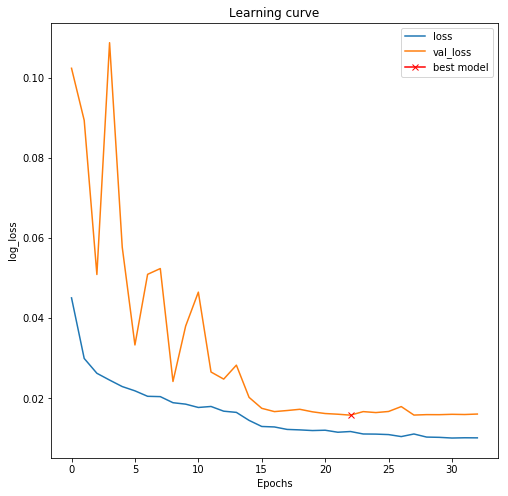

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Inference

In [13]:
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

input_img = Input((img_height, img_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", mean_IoU])
# load the best model
model.load_weights('models/model-gs-unet.h5')

In [14]:
# Evaluate on test set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

242/242 [==============================] - 2s 8ms/sample - loss: 0.2442 - accuracy: 0.9352 - mean_IoU: 0.8380


[0.2441568192371652, 0.93520576, 0.8379797]

In [15]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

242/242 [==============================] - 1s 3ms/sample


In [16]:
import random
from matplotlib import pyplot as plt
import numpy as np

def plot_sample(X, y, preds, ix=None, prob=0.5, seed=None):
    """Function to plot the results"""
    if ix is None:
        random.seed(seed)
        ix = random.randint(0, len(X)-1)

    if y is not None:
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(20, 10))
        
    axis_index = 0
    ax[axis_index].imshow(X[ix])
    ax[axis_index].set_title('Raw Input')
    ax[axis_index].axis('off')
    axis_index += 1

    if y is not None:
        ax[axis_index].imshow(y[ix].squeeze(), cmap='gray')
        ax[axis_index].set_title('Ground Truth')
        ax[axis_index].axis('off')
        axis_index += 1
    
    ax[axis_index].imshow(preds[ix].squeeze(), cmap='gray')
    ax[axis_index].set_title('Predicted Probability Map')
    ax[axis_index].axis('off')
    axis_index += 1

    binary_preds = (preds > prob).astype(np.uint8)
    ax[axis_index].imshow(binary_preds[ix].squeeze(), cmap='gray')
    ax[axis_index].set_title('Predicted Binary Map (Prob > %.2f)' % (prob))
    ax[axis_index].axis('off')
    
def plot_samples(X, y, preds, indexs=None, num_samples=1, prob=0.5, seed=None):
    """Function to plot the results"""
    if indexs is None:
        random.seed(seed)
        indexs = [random.randint(0, len(X)-1) for _ in range(num_samples)]
    else:
        num_samples = len(indexs)
        
    if y is not None:
        fig, ax = plt.subplots(num_samples, 4, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(num_samples, 3, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)    
    
    for i, ix in enumerate(indexs):
        axis_index = 0
        ax[i, axis_index].imshow(X[ix])    
        ax[i, axis_index].axis('off')
        if i == 0: ax[i, axis_index].set_title('Raw Input')
        axis_index += 1
        
        if y is not None:
            ax[i, axis_index].imshow(y[ix].squeeze(), cmap='gray')     
            ax[i, axis_index].axis('off')
            if i == 0: ax[i, axis_index].set_title('Ground Truth')
            axis_index += 1
        
        ax[i, axis_index].imshow(preds[ix].squeeze(), cmap='gray')     
        ax[i, axis_index].axis('off')
        if i == 0: ax[i, axis_index].set_title('Predicted Probability Map')
        axis_index += 1
        
        binary_preds = (preds > prob).astype(np.uint8)
        ax[i, axis_index].imshow(binary_preds[ix].squeeze(), cmap='gray')
        ax[i, axis_index].axis('off')        
        if i == 0: ax[i, axis_index].set_title('Predicted Binary Map (Prob > %.2f)' % (prob))

### Predictions on training set

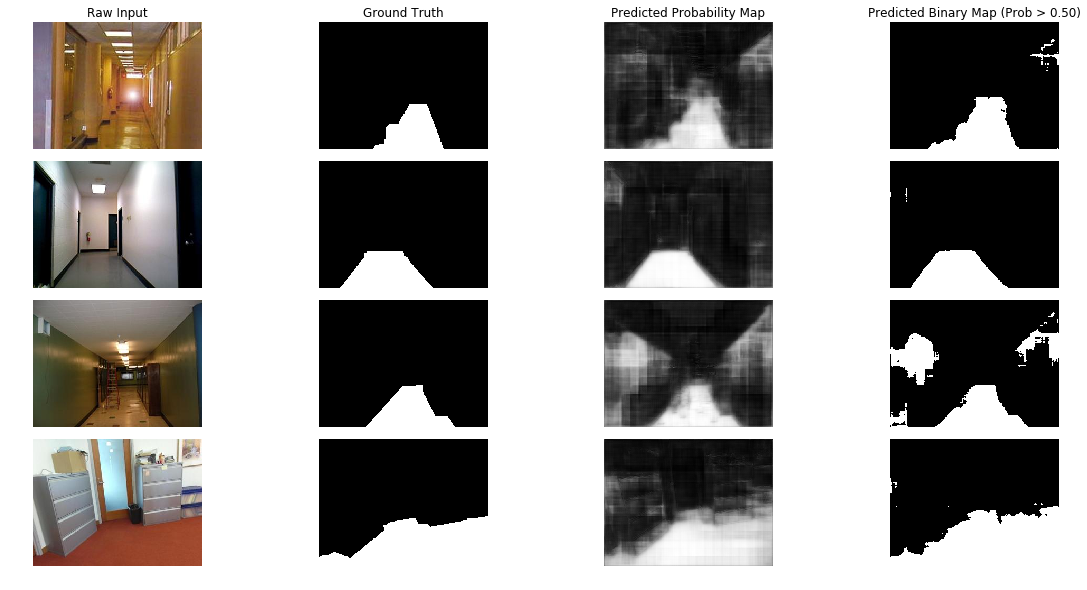

In [17]:
plot_samples(X_train, y_train, preds_train, num_samples=4, prob=0.5, seed=1)

### Predictions on test set

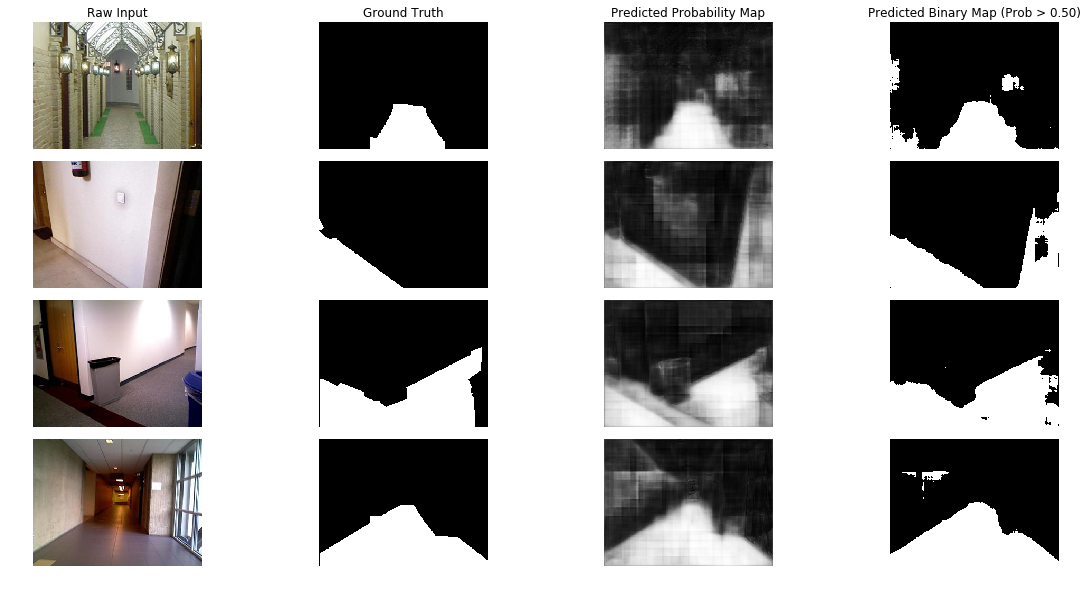

In [18]:
plot_samples(X_test, y_test, preds_test, num_samples=4, prob=0.5, seed=1)

### Predictions on selected images

In [19]:
import glob
from path import Path
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

DEMO_PATH = Path('./demo')

image_files = glob.glob(DEMO_PATH / '*.*')
X_misc = np.zeros((len(image_files), img_height, img_width, 3), dtype=np.float32)

for i, image_file in enumerate(tqdm_notebook(image_files, total=len(image_files), desc="Loading images")):
    img = load_img(image_file, grayscale=False)
    x_img = img_to_array(img)
    x_img = tf.image.resize(x_img, (img_height, img_width))
    X_misc[i] = x_img / 255.0

In [20]:
preds_misc = model.predict(X_misc, verbose=1)

9/9 [==============================] - 0s 41ms/sample


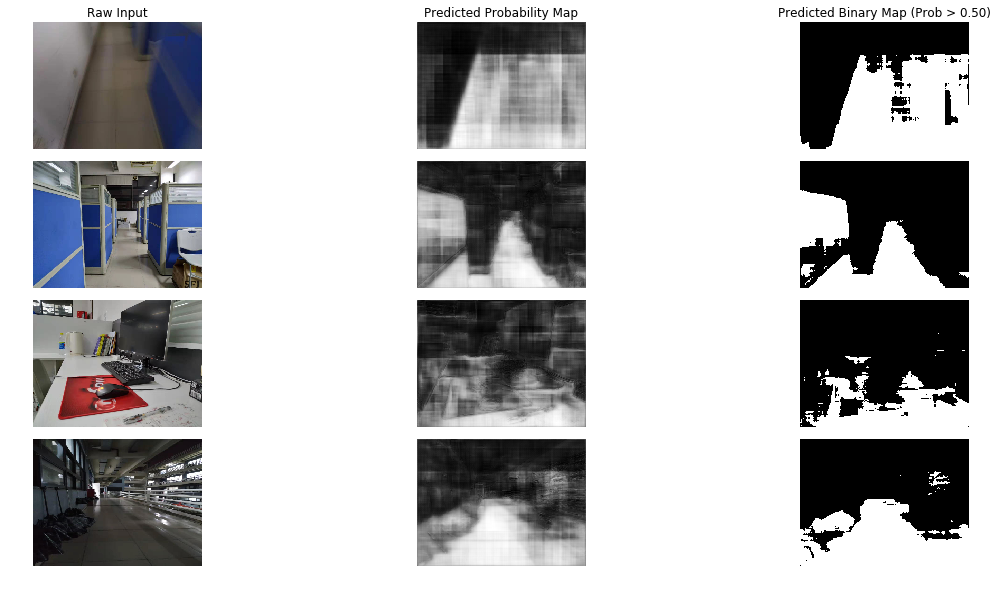

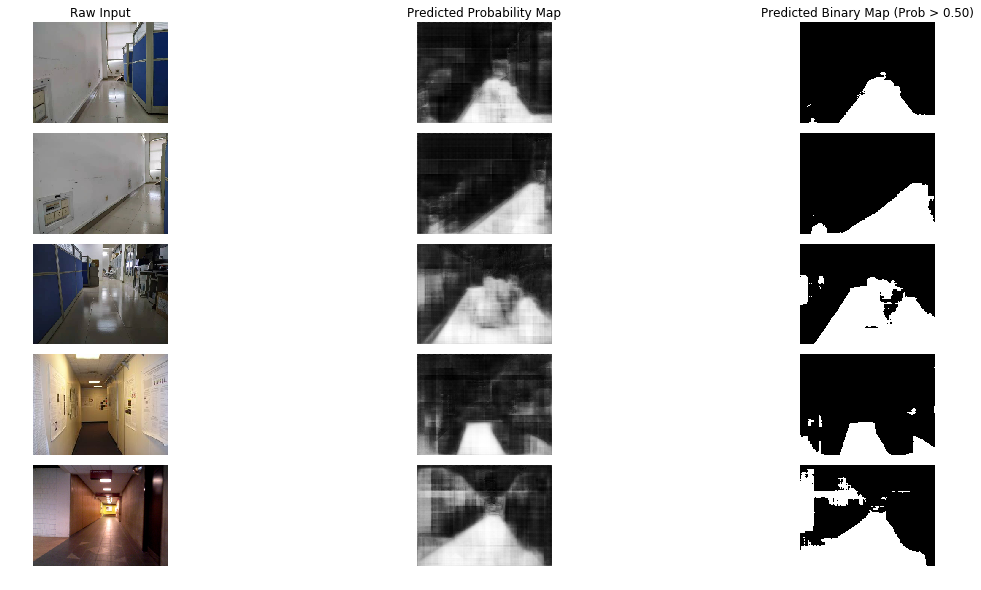

In [21]:
indexs = list(range(len(X_misc)))

plot_samples(X_misc, None, preds_misc, indexs=indexs[:len(indexs)//2], prob=0.5)
plot_samples(X_misc, None, preds_misc, indexs=indexs[len(indexs)//2:], prob=0.5)

In [22]:
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.image import resize
import os

OUTPUT_PATH = DEMO_PATH / 'predict'

if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

binary_preds = (preds_misc > 0.5).astype(np.uint8)
for index, (image, label) in enumerate((tqdm_notebook(zip(X_misc, binary_preds), total=len(X_misc), desc="Saving images and labels"))):
    image_fname = OUTPUT_PATH / 'rgb_%04d.png' % index
    label_fname = OUTPUT_PATH / 'label_%04d.png' % index
    
    image = resize(image, (480, 640))
    save_img(image_fname, image, scale=True)
    
    label = resize(label, (480, 640))
    save_img(label_fname, label, scale=True)